In [1]:
!pip -q install langchain-core langchain-community langgraph langchain-openai duckduckgo-search


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set the OPENAI_API_KEY from environment variable
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

from langchain_openai import ChatOpenAI

# Initialize ChatOpenAI with the desired model
llm = ChatOpenAI(model="gpt-4o-mini")


In [4]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
# search tools
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("How old is Brad Pitt?")

'The 60-year-old Pitt portrays Nick, ... Brad Pitt was born William Bradley Pitt on December 18, 1963, in Shawnee, Oklahoma. The eldest of three children in a devoutly Southern Baptist family, Brad ... Brad Pitt marked his 60th birthday with a celebration at Mother Wolf in Los Angeles this week. One onlooker says the actor \'looked super happy\' at the party, and \'everyone had a smile on their faces.\' Brad Pitt (born December 18, 1963, Shawnee, Oklahoma, U.S.) is an American actor known for his portrayal of unconventional characters.After gaining attention for his role in Thelma & Louise (1991), Pitt channeled his magnetism as a leading man in such movies as A River Runs Through It (1992) and Legends of the Fall (1994) but avoided being typecast by assuming unorthodox roles in 12 Monkeys ... Brad Pitt. Photo: Amy Sussman/Getty Images. Brad Pitt is opening up about growing older. The Oscar winner, 60, and George Clooney, 63, spoke with GQ in an interview published on Tuesday, August 1

In [6]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")



In [8]:
# Node
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


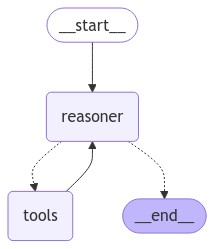

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_KO5q103MNlmFSMi7WApbRAi3)
 Call ID: call_KO5q103MNlmFSMi7WApbRAi3
  Args:
    query: Brad Pitt age 2023
================================= Tool Message =================================
Name: duckduckgo_search

Framed photo of Ines de Ramon and Brad Pitt at his birthday celebration in Los Angeles on Dec. 19, 2023. TheImageDirect.com Brad Pitt Goes Golden Cowboy for His 60th Birthday in Bold Western-Style ... Brad Pitt rang in his six-decade milestone in a big way — twice! Pitt celebrated his 60th birthday on Monday, along with friends and his girlfriend, Ines de Ramon, 33, with "low key ... Born On May 6, 1961. When Wolfs began filming in early 2023, George Clooney was 61 years old. He was born on May 6, 1961, making him Pitt's senior by two years. Wolfs ha

In [17]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [18]:
get_stock_price("AAPL")

231.41

In [22]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool

y_finance = YahooFinanceNewsTool()

y_finance.invoke("AAPL")

USER_AGENT environment variable not set, consider setting it to identify your requests.


'No news found for company that searched with AAPL ticker.'

In [23]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}


In [24]:
tools = [add, multiply, divide, search, get_stock_price]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [25]:
tools[4]

<function __main__.get_stock_price(ticker: str) -> float>

In [26]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]


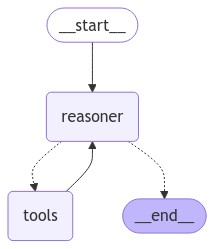

In [27]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode


# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})

In [29]:
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

Brad Pitt is 60 years old, so 2 times his age is 120.


In [30]:
response = react_graph.invoke({"query": "What is the stock price of Apple?", "messages": []})

In [31]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_E9HU4FxewH8NePO4MG41PtbN)
 Call ID: call_E9HU4FxewH8NePO4MG41PtbN
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

231.41
================================ Human Message =================================

What is the stock price of Apple?
================================== Ai Message ==================================

The stock price of Apple (AAPL) is $231.41.


In [32]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})

In [33]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Wh0I9QgOZKTViyjugoZS34y5)
 Call ID: call_Wh0I9QgOZKTViyjugoZS34y5
  Args:
    query: Jensen Huang CEO company
================================= Tool Message =================================
Name: duckduckgo_search

Jensen Huang: from Denny's dishwasher to CEO of Nvidia | 60 Minutes 13:23. Only four companies in the world are worth more than $2 trillion: Microsoft, Apple, Alphabet — parent company of Google ... From the Editor. Jensen Huang cofounded graphics-chip maker Nvidia in 1993 and has served as its CEO and president ever since. Huang owns approximately 3% of Nvidia, which he took public in 1999 ... Nvidia pressed ahead in March, when CEO Jensen Huang unveiled Blackwell, the company's latest GPU. Designed in Americ

In [34]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?", "messages": []})

In [35]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_DBBHiGR7u7dDH8bo2XHDBh0w)
 Call ID: call_DBBHiGR7u7dDH8bo2XHDBh0w
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

141.54
================================ Human Message =================================

What will be the price of nvidia stock if it doubles?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UK3Fogpn5ggNEXTeVC6Cwcu4)
 Call ID: call_UK3Fogpn5ggNEXTeVC6Cwcu4
  Args:
    a: 141.54
    b: 2
================================= Tool Message =================================
Name: multiply

Error: 1 validation error for multiply
a
  Input should be a valid integer, got a number with a fractiona

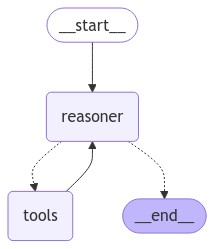

In [36]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))